# Binary Classification of the "Don't Patronize Me!" Dataset

Perform Binary Classification to predict whether a text contains patronizing and condescending language. The task was task 4 (subtask 1) in the SemEval 2022 competition.

## Initialize Environment

In [65]:
# Library imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
import scipy

data_path = '../data'


## Raw Data

### Loading

Load the data into pandas dataframes

In [ ]:
# Import Data
train_data_path = f'{data_path}/dontpatronizeme_pcl.tsv'
test_data_path  = f'{data_path}/task4_test.tsv'

train_data = pd.read_csv(train_data_path, delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text','label'])
test_data  = pd.read_csv(test_data_path,  delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text'])

train_data = train_data.drop(['art_id'], axis=1)
test_data = test_data.drop(['art_id'], axis=1)

In [ ]:
# Concatenate label information to train data
dev_label_path   = f'{data_path}/dev_semeval_parids-labels.csv'
train_label_path = f'{data_path}/train_semeval_parids-labels.csv'

dev_label   = pd.read_csv(dev_label_path, delimiter=',')
train_label = pd.read_csv(train_label_path, delimiter=',')

detailed_labels = pd.concat([dev_label, train_label], ignore_index=True, join='inner', names=['simple', 'detailed'])
train_data = pd.merge(train_data, detailed_labels, on='par_id')
train_data = train_data.rename(columns={'label_x': 'label', 'label_y': 'label_detailed'})

train_data = train_data.drop('par_id', axis=1)
test_data = test_data.drop('par_id', axis=1)

In [ ]:
# Add Binary Classification column for ease of checking
train_data.loc[:, 'is_patronizing'] = 0
train_data.loc[train_data['label'].isin([2,3,4]), 'is_patronizing'] = 1

In [ ]:
train_data = train_data.dropna(subset = 'text')
test_data = test_data.dropna(subset = 'text')

## Pre-Processing

## Data Splits

split the data whilst keeping distributions of country, text and is_patronizing counts even

In [ ]:
X = train_data['text']
y = train_data['is_patronizing']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

## Multinomial Naive Bayes Classifier Model

In [134]:
# First, we get the vocabulary
vocab = set()
for document in X_train:
    for word in document.split():
        vocab.add(word)

vocab = sorted(list(vocab))
X_train_BoW = np.zeros((len(X_train), len(vocab)), dtype=int)
y_train_arr = np.zeros(len(X_train), dtype=int)

for idx, (document, is_pcl) in enumerate(zip(X_train, y_train)):
    # Get word counts
    for v_idx, word in enumerate(vocab):
        X_train_BoW[idx, v_idx] = document.split().count(word)
    y_train_arr[idx] = is_pcl

    if idx % 500 == 0:
        print(f"Train data: {idx}/{len(X_train)}")

# Now do the same for test data. Obviously, use the vocab we got from the train
# data!
X_test_BoW = np.zeros((len(X_test), len(vocab)), dtype=int)
y_test_arr = np.zeros(len(X_test), dtype=int)
for idx, (document, is_pcl) in enumerate(zip(X_test, y_test)):
    for v_idx, word in enumerate(vocab):
        X_test_BoW[idx, v_idx] = document.split().count(word)

    y_test_arr[idx] = is_pcl

    if idx % 500 == 0:
        print(f"Test data: {idx}/{len(X_test)}")



Train data: 0/8374
Train data: 500/8374
Train data: 1000/8374
Train data: 1500/8374
Train data: 2000/8374
Train data: 2500/8374
Train data: 3000/8374
Train data: 3500/8374
Train data: 4000/8374
Train data: 4500/8374
Train data: 5000/8374
Train data: 5500/8374
Train data: 6000/8374
Train data: 6500/8374
Train data: 7000/8374
Train data: 7500/8374
Train data: 8000/8374
Test data: 0/2094
Test data: 500/2094
Test data: 1000/2094
Test data: 1500/2094
Test data: 2000/2094


In [135]:
# Sanity check
print(X_train)
print(X_train[3065])

for i, w in enumerate(vocab):
    count = X_train_BoW[0, i]
    if count > 0:
        print(f"{w} appears {count} times") 


3065    A good number of Rohingya refugees became vote...
9216    When we read this passage , we can see that Jo...
7362    Ping charges are much stronger than any that h...
1166    At 1.3 seconds before impact , the self-drivin...
3986    He said if employers continue to risk arrest a...
                              ...                        
9226    Part of the church 's collection also goes tow...
4859         1,188 homeless get jobs , return to families
3264    The Turkish Ambassador to Tanzania Ali Davutog...
9846    Kakamega County women 's representative Elsie ...
2732    One of the jurors in the Belgium tribunal that...
Name: text, Length: 8374, dtype: object
A good number of Rohingya refugees became voters , particularly in the country 's southeastern districts , including Cox 's Bazar , Chittagong and Bandarban in 2008 as the Rohingya issue did not get the due attention at that time , said Election Commission officials .
's appears 2 times
, appears 4 times
. appears 1 time

In [152]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

def draw_confusion_matrix(model, X, y, title):
    y_pred = model.predict(X)

    cm = confusion_matrix(y, y_pred, labels=[0, 1]) 

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))  

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

    ax.set_title(title)

    ax.xaxis.set_ticklabels(['Not Patronizing', 'Patronizing'])
    ax.yaxis.set_ticklabels(['Not Patronizing', 'Patronizing'])
    print("======= CLASSIFICATION REPORT:", title, "=======")
    print(classification_report(y_train, y_train_pred))
    plt.show()

/home/ysera/root/education/uni/y4/t2/nlp/venv/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


======= CLASSIFICATION REPORT: Gaussian naive bayes confusion matrix for test set =======
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7585
           1       1.00      0.94      0.97       789

    accuracy                           0.99      8374
   macro avg       1.00      0.97      0.98      8374
weighted avg       0.99      0.99      0.99      8374



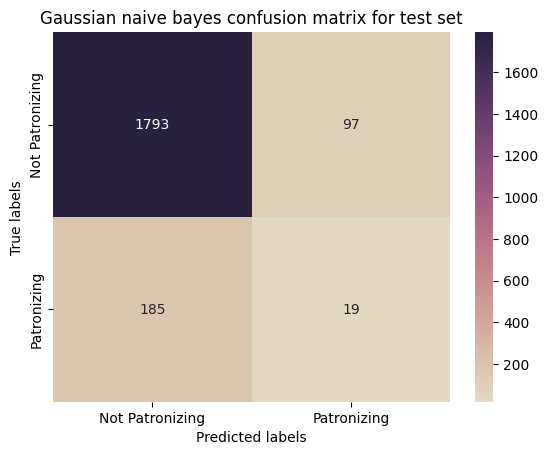

======= CLASSIFICATION REPORT: Logistic regression confusion matrix for test set =======
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7585
           1       1.00      0.94      0.97       789

    accuracy                           0.99      8374
   macro avg       1.00      0.97      0.98      8374
weighted avg       0.99      0.99      0.99      8374



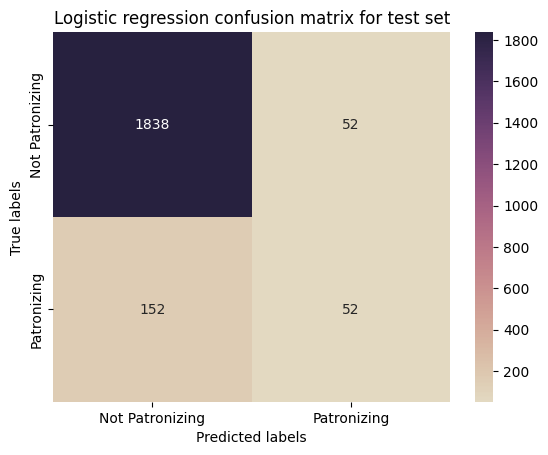

In [153]:
# Train model
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

naive_bayes = GaussianNB()
naive_bayes.fit(X_train_BoW, y_train_arr)

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_BoW, y_train_arr)

draw_confusion_matrix(naive_bayes, X_test_BoW, y_test_arr, "Gaussian naive bayes confusion matrix for test set")
draw_confusion_matrix(logistic_regression, X_test_BoW, y_test_arr, "Logistic regression confusion matrix for test set")

## Submission Documents

In [ ]:
def get_and_save_predictions(dataset, save_name, model=task1_model):
    y_pred, _ = model.predict(dataset.tolist())
    np.savetxt(f'{save_name}.txt', y_pred, fmt='%d')

# train predictions
get_and_save_predictions(test_data['text'], "test")

# test predictions
get_and_save_predictions(train_data['text'], "dev")